## Données simulées 
- simulation d'un mélange de deux gaussiennes
- simulation de données normales gaussiennes et d'anomalies uniformes


In [14]:
!pip install pyod
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pyod.models.knn import KNN
from pyod.models.ocsvm import OCSVM
from scipy import stats
import seaborn as sns
import pickle as pkl
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 2.1MB 8.0MB/s 
  Created wheel for pyod: filename=pyod-0.7.8.2-cp36-none-any.whl size=104997 sha256=4fb688258c6e43307f80bcafb3ca23ebd31b12348d585458db49f71d527cbf31
  Stored in directory: /root/.cache/pip/wheels/28/38/ec/0ecbcd67faeb595ac0dbd9b5f85d5c5bdcb4573819e65240fe
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=1db2161ba626ef561c3959d8d8dc3c180ea982829cbe87999d3932f69d42e2ee
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=2d17bf4df5ed176e5fdbd3eeb1c53880e5e566c779e03d46f411a2128636c696
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [0]:
def plot_var_in_out(X,y,var1,var2,var3,var4):
    x1 = X[:,var1]
    x2 = X[:,var2]
    x3 = X[:,var3]
    x4 = X[:,var4]

    fig = plt.figure(figsize=(20,18))

    ax0 = fig.add_subplot(5,3,1)
    ax0.scatter(x1, x2, alpha=0.7, c=y)
    ax0.set_title('Représentation des données selon les variables ' +str(var1)+ ' et '+ str(var2))
    ax0.set_xlabel('variable '+str(var1)) 
    ax0.set_ylabel('variable '+str(var2)) 

    ax1 = fig.add_subplot(5,3,2)
    ax1.scatter(x1, x3, alpha=0.5,  c=y)
    ax1.set_title('Représentation des données selon les variables ' +str(var1)+ ' et '+ str(var3))
    ax1.set_xlabel('variable '+str(var1))
    ax1.set_ylabel('variable '+str(var3))

    ax2 = fig.add_subplot(5,3,3)
    ax2.scatter(x1, x4, alpha=0.5,  c=y)
    ax2.set_title('Représentation des données selon les variables ' +str(var1)+ ' et '+ str(var4))
    ax2.set_xlabel('variable '+str(var1))
    ax2.set_ylabel('variable '+str(var4))

    plt.tight_layout()
    plt.show()

In [0]:
def evaluate(ytrue,ypred):
  
    CM = confusion_matrix(ytrue, ypred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    metrics = pd.DataFrame([],columns=['accuracy','recall','True negative rate','False discovery rate'])
    metrics['accuracy'] = [accuracy_score(ytrue,ypred)]
    metrics['recall'] = [recall_score(ytrue,ypred,average='macro')]
    metrics['True negative rate'] = [FN/(TP+FN)]
    metrics['False discovery rate'] = [FP/(TP+FP)]

    return metrics

In [0]:
def evaluation_detection(ytrue,ypred):
    # x1 = X_test[:,10]
    # x2 = X_test[:,20]
    x1 = X_test[:,0]
    x2 = X_test[:,1]

    fig = plt.figure(figsize=(14,18))

    ax0 = fig.add_subplot(5,3,1)
    ax0.scatter(x1, x2, alpha=0.7, c=ytrue)
    ax0.set_title('Représentation des données selon le vrai label')
    ax0.set_xlabel('x1') 
    ax0.set_xlabel('x2') 

    ax1 = fig.add_subplot(5,3,2)
    colors = np.array(['#377eb8', '#ff7f00']) 
    ax1.scatter(x1, x2, alpha=0.5,  c=ypred)
    ax1.set_title('Représentation des données selon le label prédit')
    ax1.set_ylabel('x1')
    ax1.set_ylabel('x2')

    ax2 = fig.add_subplot(5,3,3)
    data = confusion_matrix(ytrue, ypred)
    labels = ['Outlier', 'Inliers']
    sns.heatmap(data, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", ax=ax2) 
    ax2.set_title('Matrice de confusion')

    plt.tight_layout()
    plt.show()
    
    
def deep_predict(model,X_test):
    ypred = model.predict(X_test_scaled)
    mse = np.mean(np.power(X_test_scaled - ypred, 2), axis=1)
    df_error = pd.DataFrame({'reconstruction_error': mse})
    outliers = df_error.index[df_error.reconstruction_error > outlier_prop].tolist()
    y_pred = np.ones(len(y_test))
    y_pred[outliers] = -1
    return y_pred

In [0]:
# import pickle as pkl

np.random.seed(0)
mean_normal = np.random.randint(0,10,1000)
std_normal = np.identity(1000)
normal_data = np.random.multivariate_normal(mean_normal,std_normal,size = 1000)

mean0_min1 = np.copy(mean_normal)
mean0_min1[0] = mean_normal[0]-1

mean0_min10 = np.copy(mean_normal)
mean0_min10[0] = mean_normal[0]-10

mean0to9_min1 = np.copy(mean_normal)
mean0to9_min1[0:10] = mean_normal[0:10]-1

list_mean = [mean0_min1,mean0_min10,mean0to9_min1]
list_mean
anomaly_list_01 = []
anomaly_list_1 = []
anomaly_list_10 = []
for i in range(len(list_mean)):
    anomaly_list_01.append(np.random.multivariate_normal(list_mean[i],np.identity(1000)/10,size = 100))
    anomaly_list_1.append(np.random.multivariate_normal(list_mean[i],np.identity(1000),size = 100))
    anomaly_list_10.append(np.random.multivariate_normal(list_mean[i],np.identity(1000)*10,size = 100))

In [103]:
uniform_anomaly = np.random.uniform(-5,15,size=(100,1000))
print(uniform_anomaly.shape)

(100, 1000)


In [106]:
uniform_anomaly2 = np.random.uniform(0,10,size=(100,1000))
print(uniform_anomaly2.shape)

(100, 1000)


In [0]:
# pkl.dump({"list_mean":list_mean,"anomaly_list01":anomaly_list_01,
#           "anomaly_list1":anomaly_list_1,"anomaly_list10":anomaly_list_10},open("pickles/save_gauss.pkl","wb"))

In [63]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

nb_epoch = 200
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_23 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_24 (Dense)             (None, 1000)              1100

In [0]:
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["KNN","Local Outlier Factor","Deep MLP","Robust covariance"]

# Première représentation

## Gaussiennes

%%%%%%%%%%%%%%%%%% index =  0


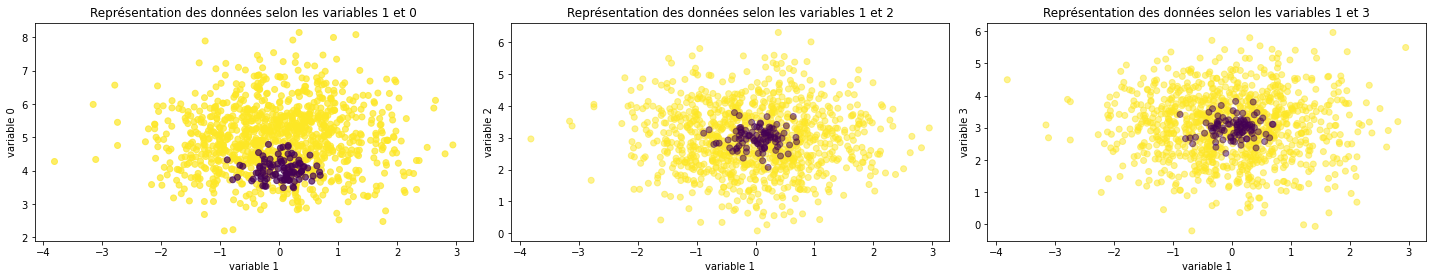

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.981818  0.861111                 0.0              0.019084


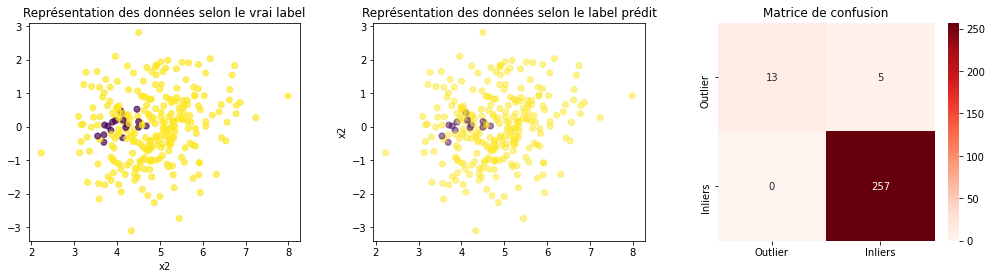

---------One-Class SVM-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.796364  0.42607             0.14786              0.075949


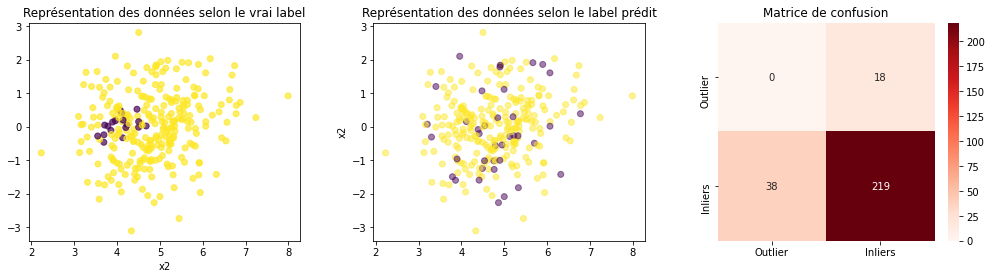

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.894545  0.478599            0.042802              0.068182


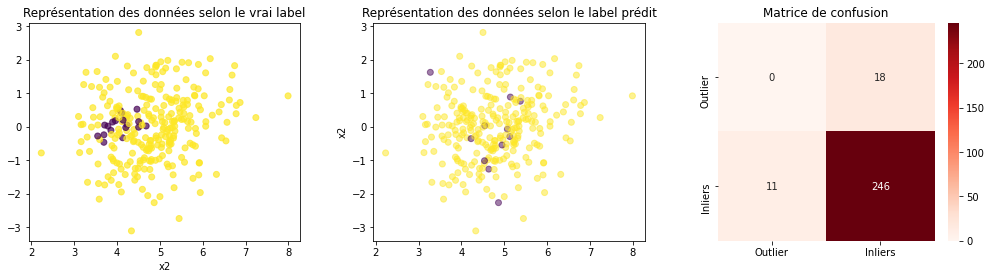

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.898182  0.480545            0.038911              0.067925


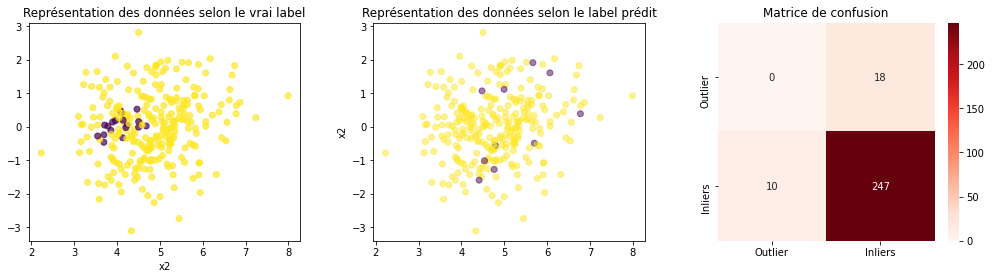

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


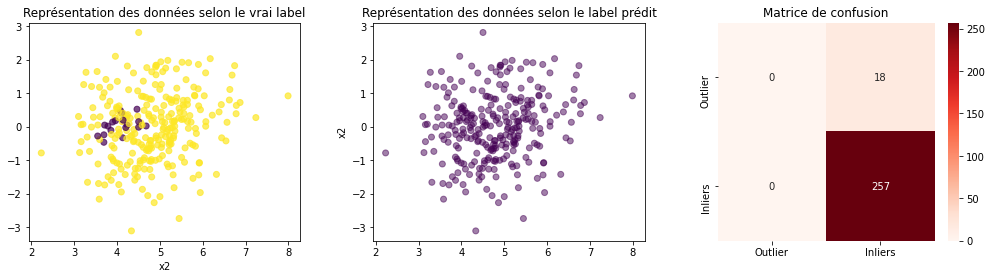

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


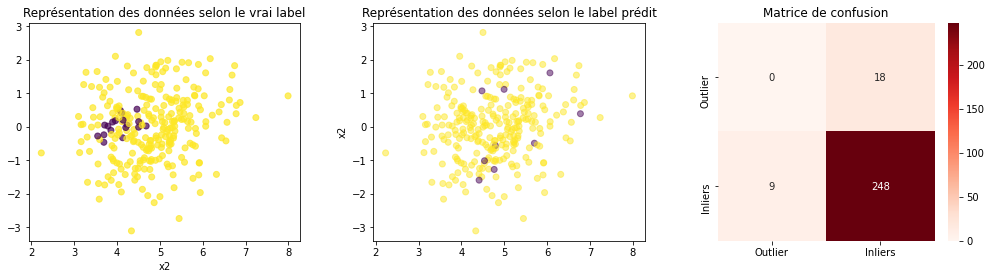

%%%%%%%%%%%%%%%%%% index =  1


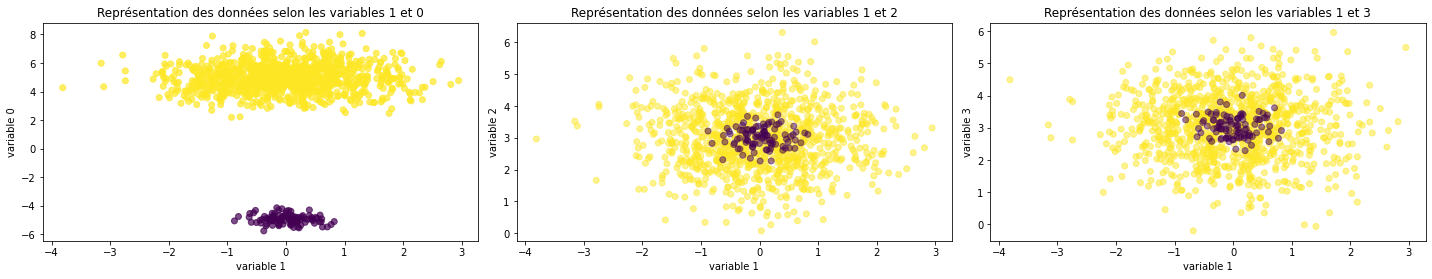

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.996364  0.972222                 0.0              0.003876


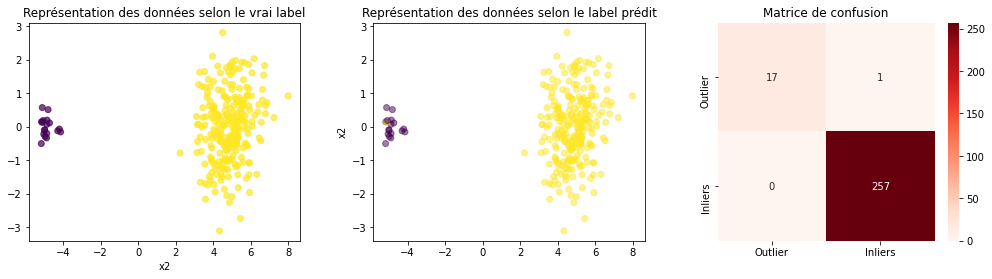

---------One-Class SVM-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.796364  0.42607             0.14786              0.075949


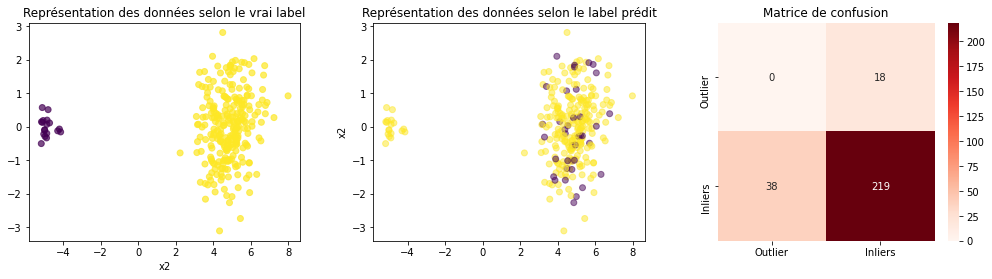

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.876364  0.468872            0.062257              0.069498


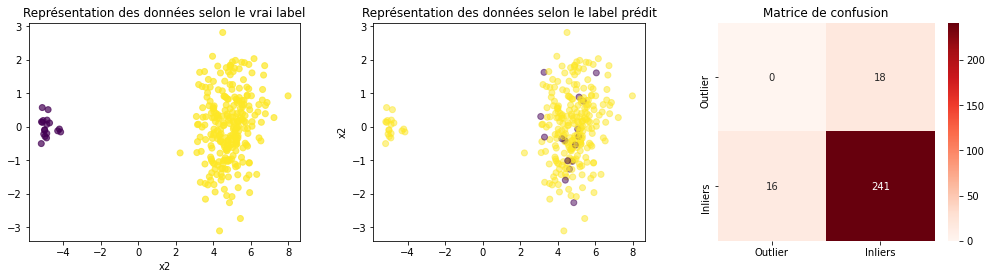

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.916364  0.490272            0.019455              0.066667


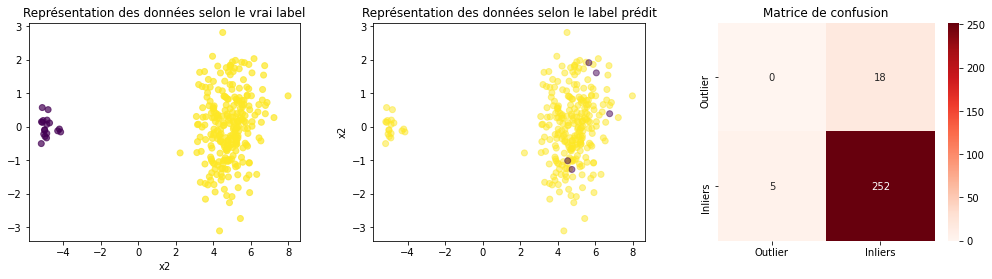

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


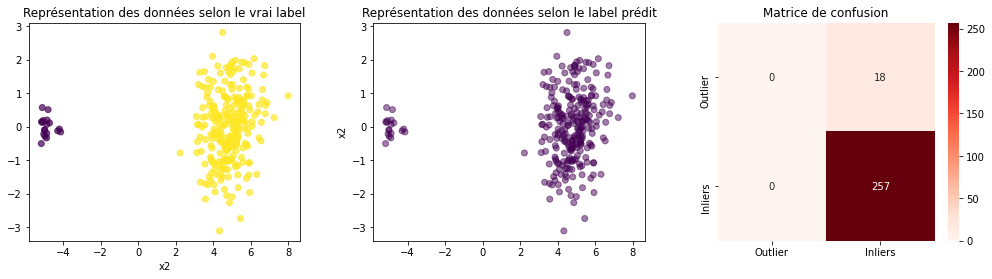

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


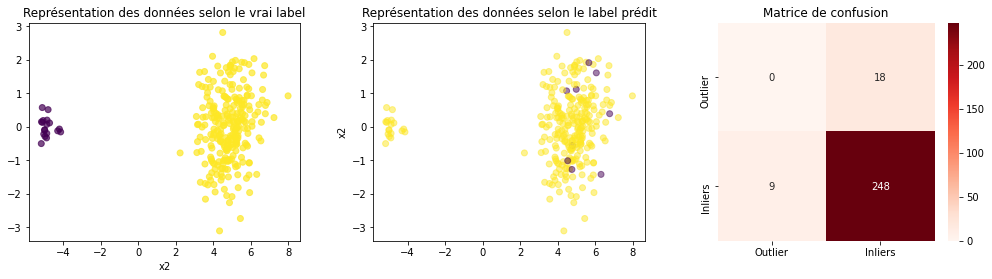

%%%%%%%%%%%%%%%%%% index =  2


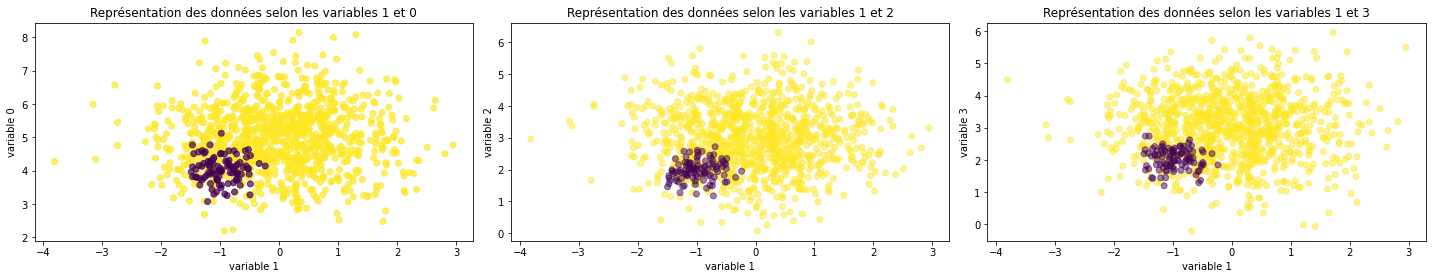

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.981818  0.861111                 0.0              0.019084


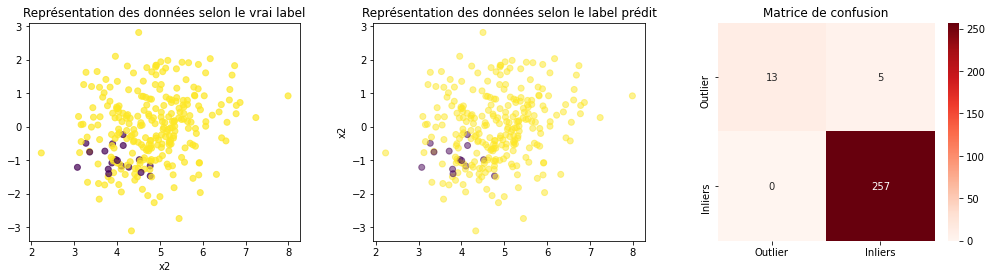

---------One-Class SVM-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.796364  0.42607             0.14786              0.075949


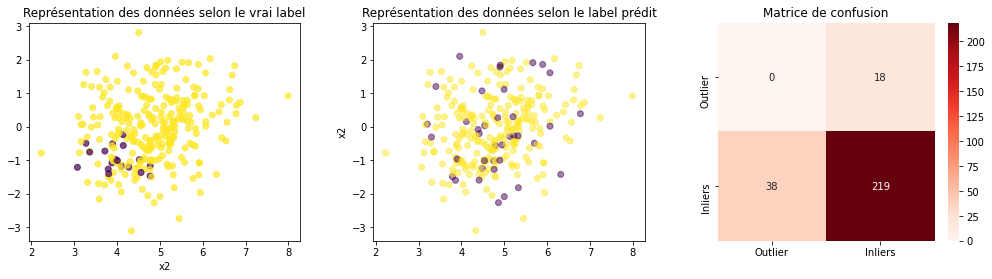

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.890909  0.476654            0.046693              0.068441


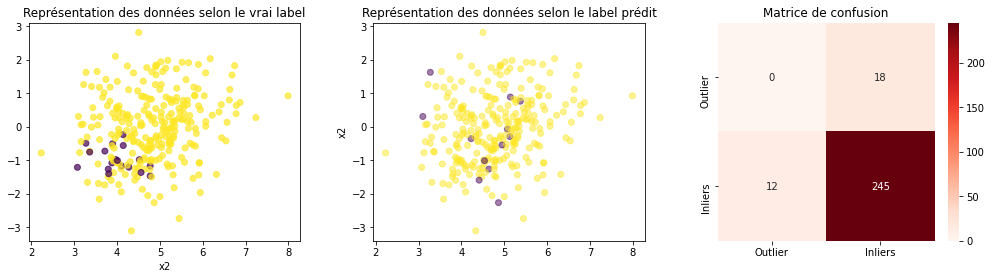

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.905455  0.484436            0.031128              0.067416


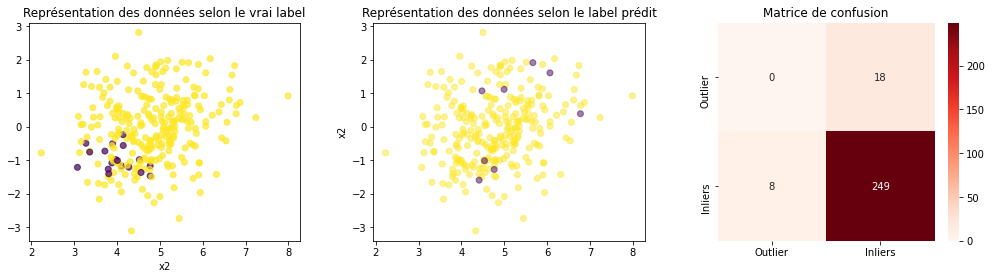

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


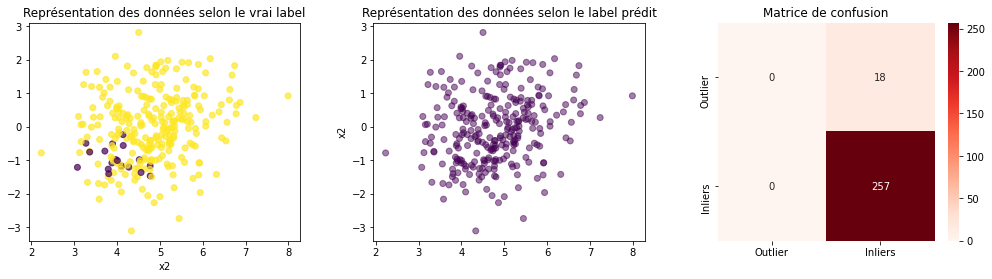

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


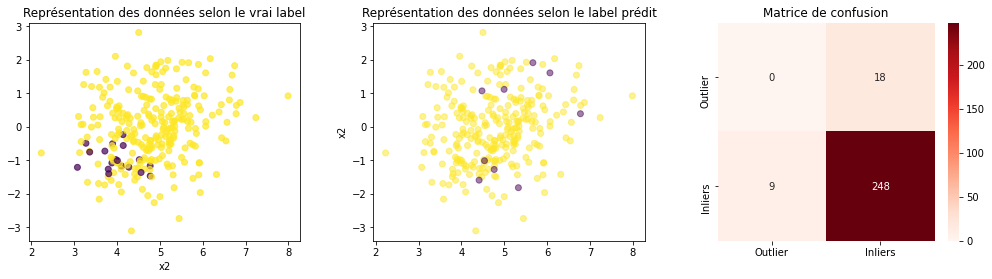

In [88]:
for index in range(len(anomaly_list_01)):
  print("%%%%%%%%%%%%%%%%%% index = ",index)
  X = np.concatenate([normal_data,anomaly_list_01[index]])
  y = np.concatenate([np.ones(1000),-np.ones(100)])

  plot_var_in_out(X,y,1,0,2,3)

  #outlier_prop = len(y[y==-1])/len(y) #0.012
  outlier_prop = 0.03

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled  = scaler.transform(X_test)

  for name, algorithm in anomaly_algorithms:
    if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      y_pred[y_pred == 1] = -1
      y_pred[y_pred == 0] = 1
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Local Outlier Factor":
      algorithm.fit(X_train)
      y_pred = algorithm.fit_predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Deep MLP":
      algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
      y_pred = deep_predict(algorithm,X_test_scaled)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    
    if name == "Robust covariance" :
      algorithm.fit(X_train)
      y_pred = -algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

    if name not in algo_particuliers:
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

%%%%%%%%%%%%%%%%%% index =  0


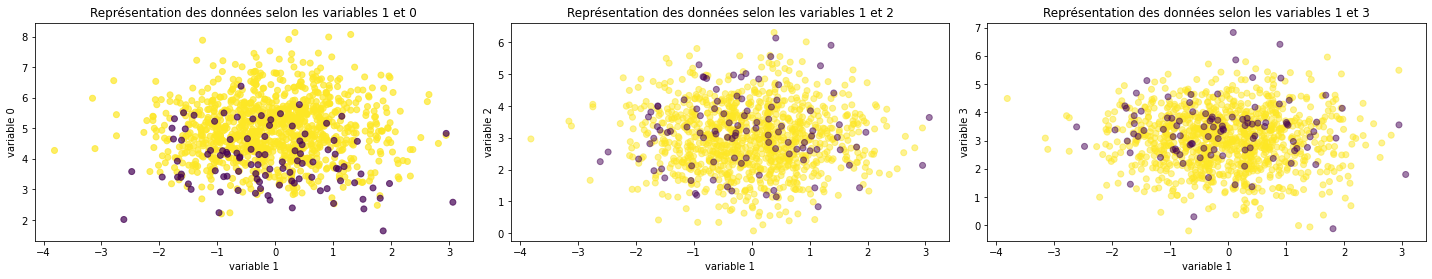

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


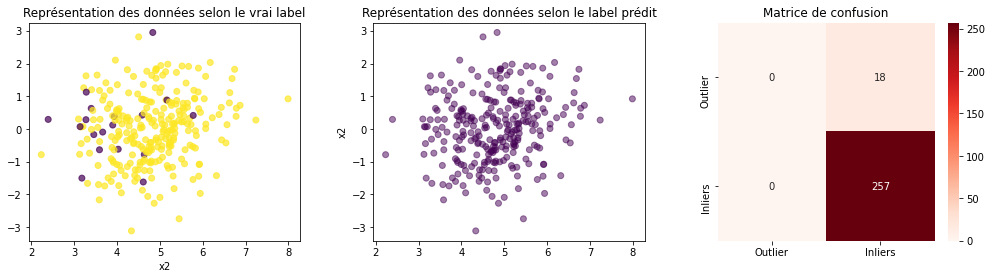

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.810909  0.537181             0.14786              0.060086


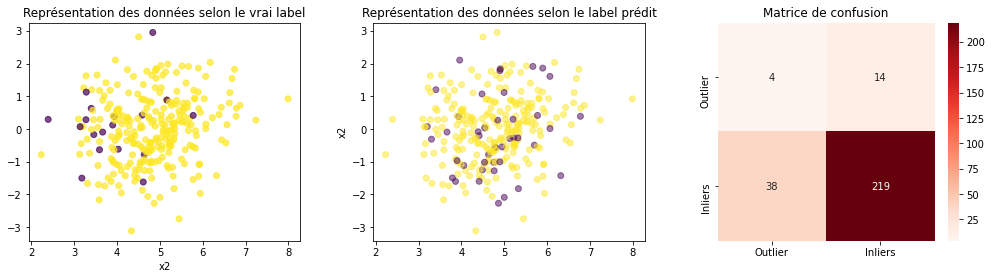

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.909091  0.538046            0.035019              0.060606


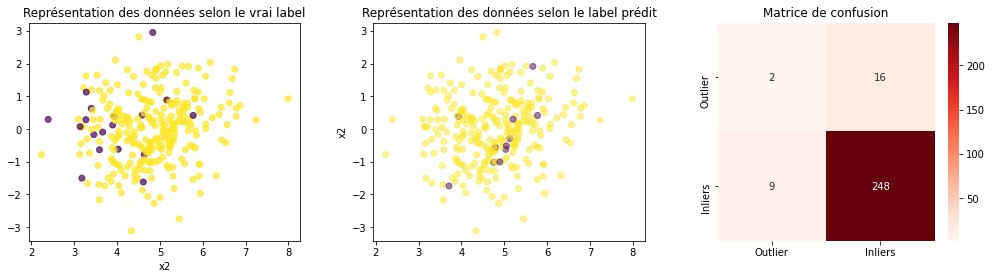

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.901818  0.508323            0.038911              0.064394


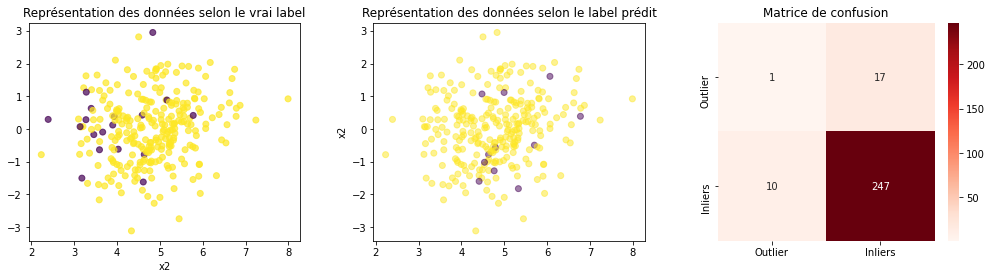

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


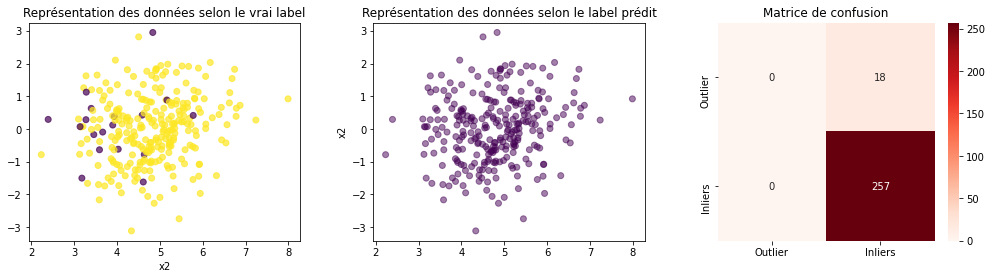

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.909091  0.512214            0.031128               0.06391


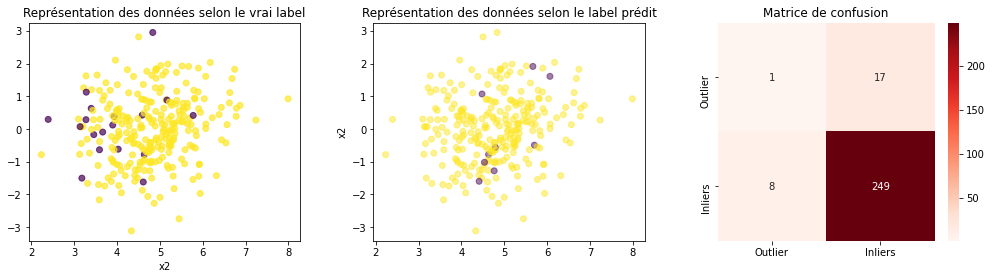

%%%%%%%%%%%%%%%%%% index =  1


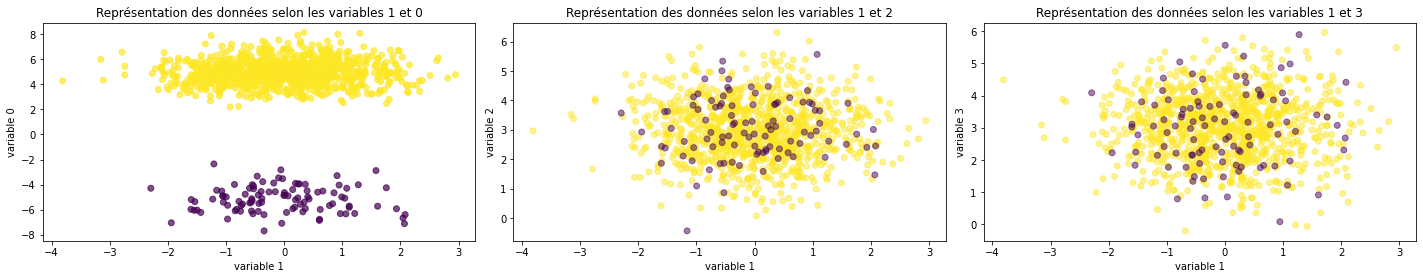

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


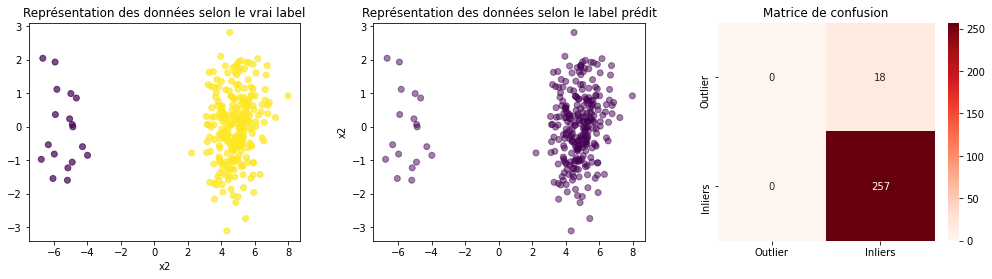

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.872727  0.647752            0.093385              0.045082


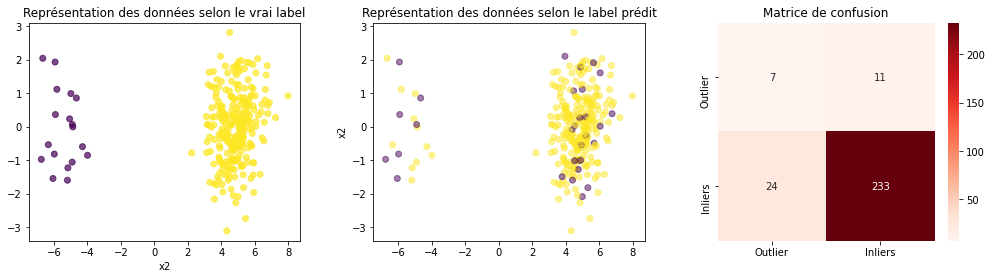

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.869091  0.516645            0.077821              0.063241


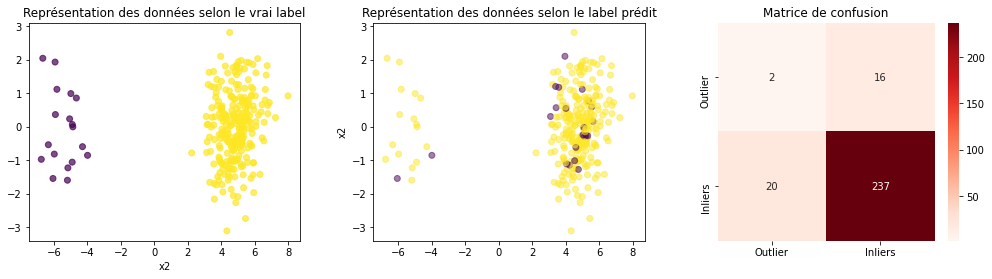

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.934545  0.577497            0.011673              0.055762


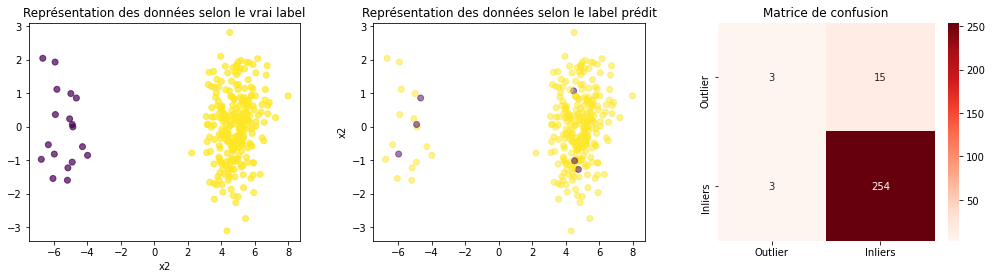

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


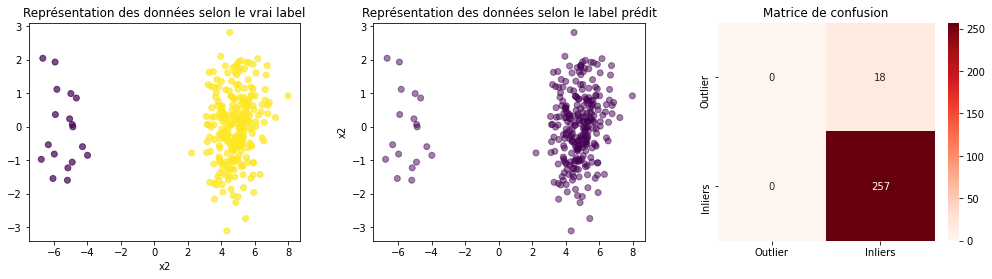

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.930909  0.601383            0.019455              0.052632


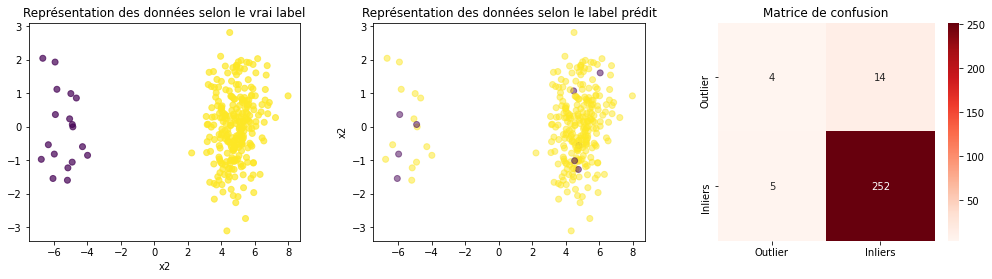

%%%%%%%%%%%%%%%%%% index =  2


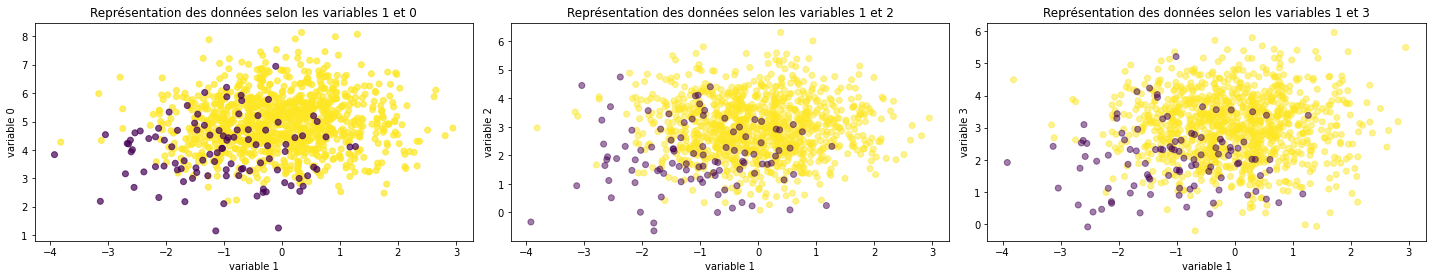

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


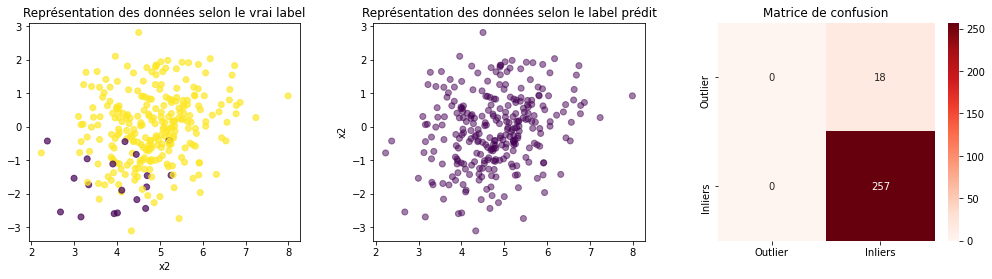

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.836364  0.524968            0.116732              0.061983


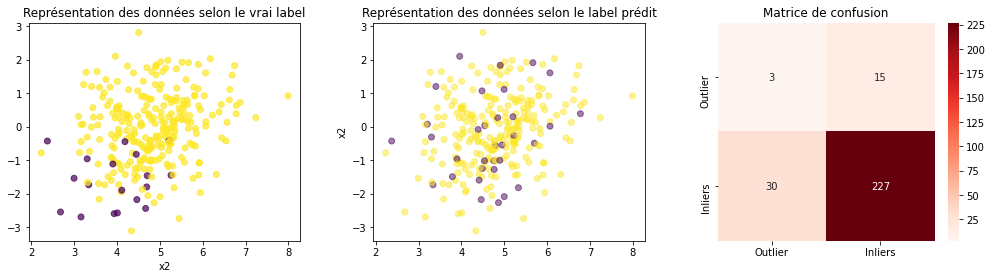

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.909091  0.512214            0.031128               0.06391


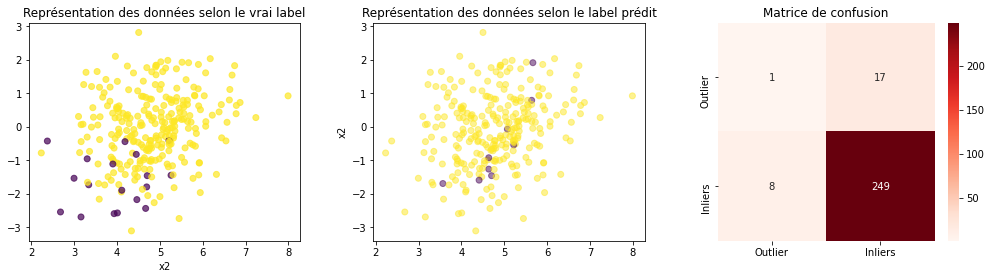

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.905455  0.484436            0.031128              0.067416


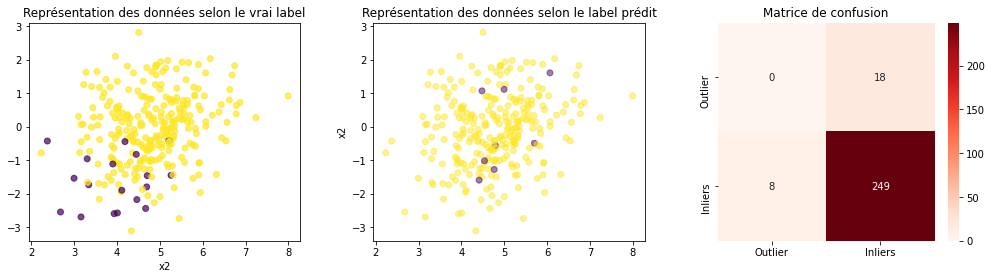

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


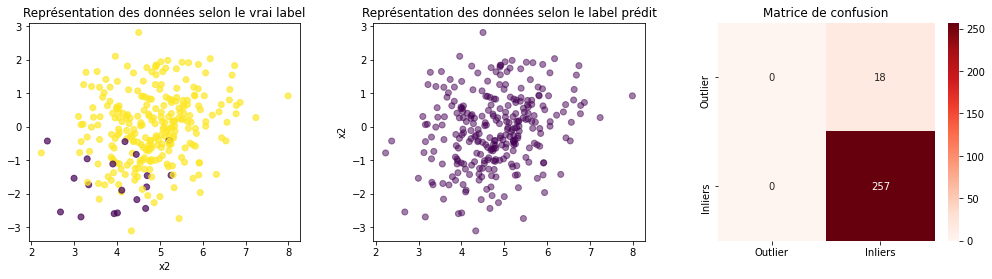

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


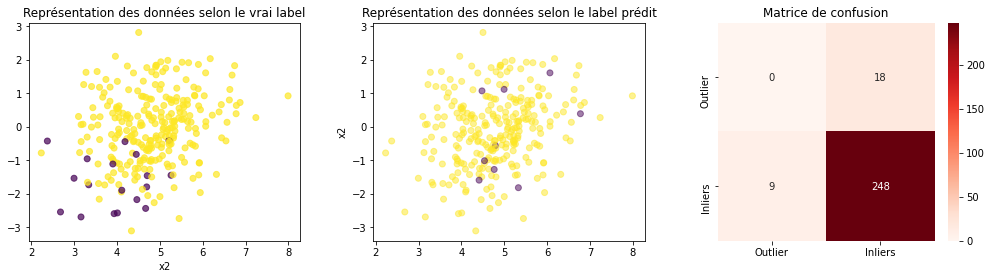

In [89]:
## std of 1

for index in range(len(anomaly_list_1)):
  print("%%%%%%%%%%%%%%%%%% index = ",index)
  X = np.concatenate([normal_data,anomaly_list_1[index]])
  y = np.concatenate([np.ones(1000),-np.ones(100)])

  plot_var_in_out(X,y,1,0,2,3)

  #outlier_prop = len(y[y==-1])/len(y) #0.012
  outlier_prop = 0.03

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled  = scaler.transform(X_test)

  for name, algorithm in anomaly_algorithms:
    if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      y_pred[y_pred == 1] = -1
      y_pred[y_pred == 0] = 1
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Local Outlier Factor":
      algorithm.fit(X_train)
      y_pred = algorithm.fit_predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Deep MLP":
      algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
      y_pred = deep_predict(algorithm,X_test_scaled)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    
    if name == "Robust covariance" :
      algorithm.fit(X_train)
      y_pred = -algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

    if name not in algo_particuliers:
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

## Uniforme

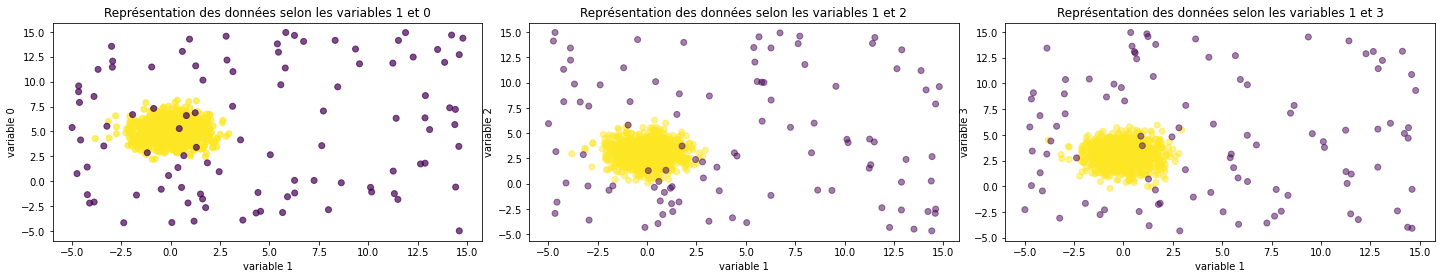

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


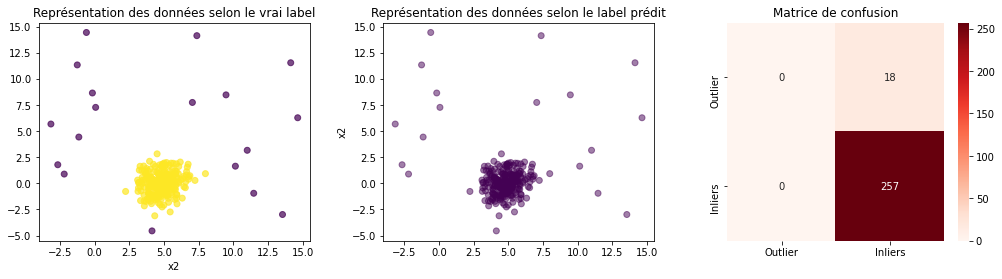

---------One-Class SVM-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


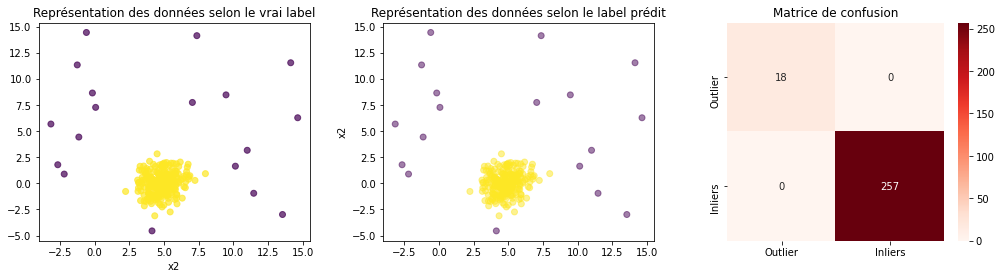

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0      0.96  0.694444                 0.0              0.041045


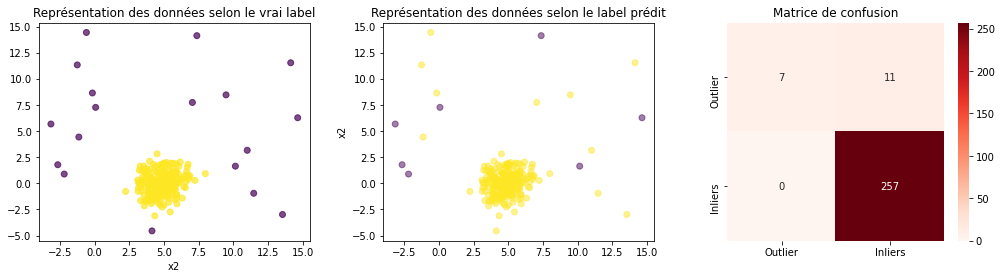

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.945455  0.583333                 0.0              0.055147


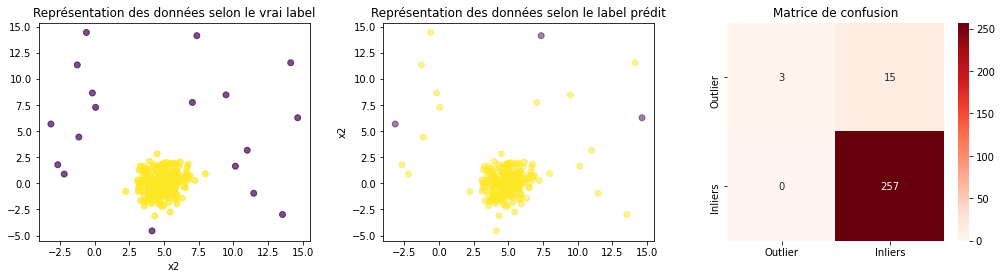

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


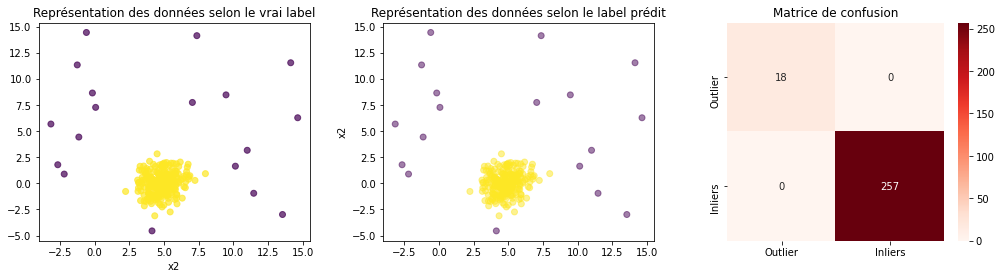

---------Local Outlier Factor-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.967273    0.75                 0.0              0.033835


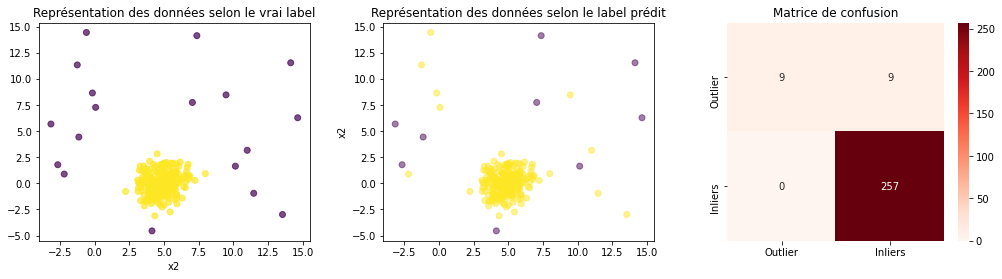

In [104]:
X = np.concatenate([normal_data,uniform_anomaly])
y = np.concatenate([np.ones(1000),-np.ones(100)])

plot_var_in_out(X,y,1,0,2,3)

#outlier_prop = len(y[y==-1])/len(y) #0.012
outlier_prop = 0.03

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

for name, algorithm in anomaly_algorithms:
  if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    y_pred[y_pred == 1] = -1
    y_pred[y_pred == 0] = 1
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Local Outlier Factor":
    algorithm.fit(X_train)
    y_pred = algorithm.fit_predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Deep MLP":
    algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
    y_pred = deep_predict(algorithm,X_test_scaled)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  
  if name == "Robust covariance" :
    algorithm.fit(X_train)
    y_pred = -algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)

  if name not in algo_particuliers:
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)

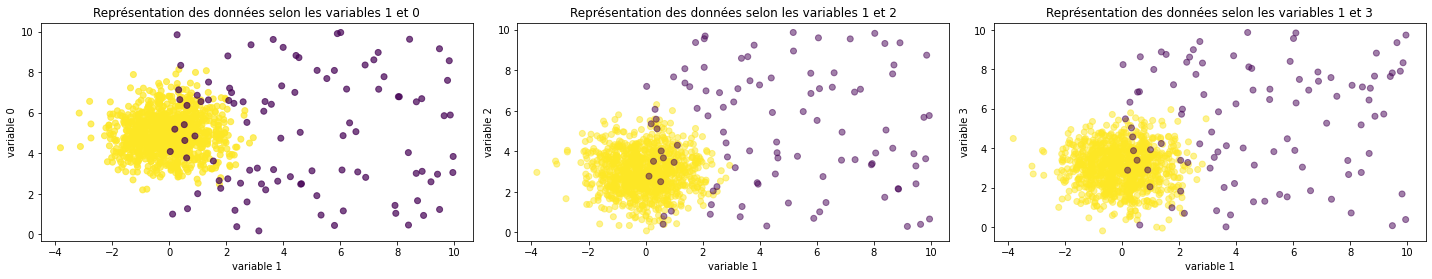

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


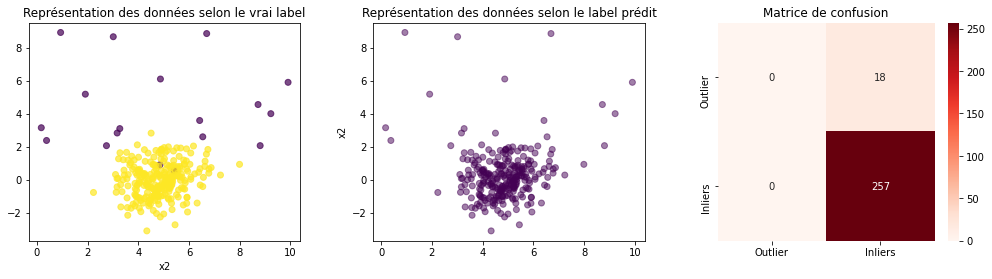

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.978182  0.988327            0.023346                   0.0


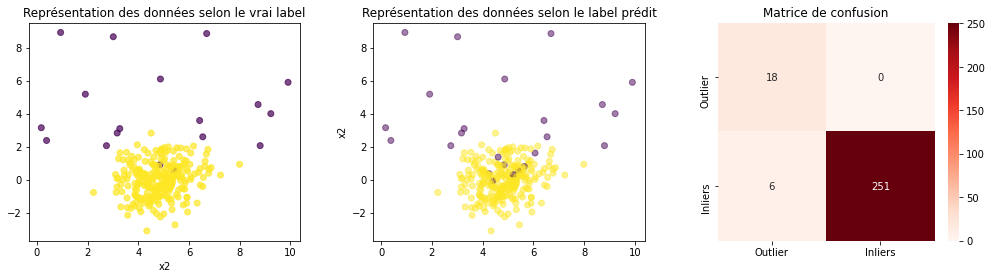

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.978182  0.833333                 0.0              0.022814


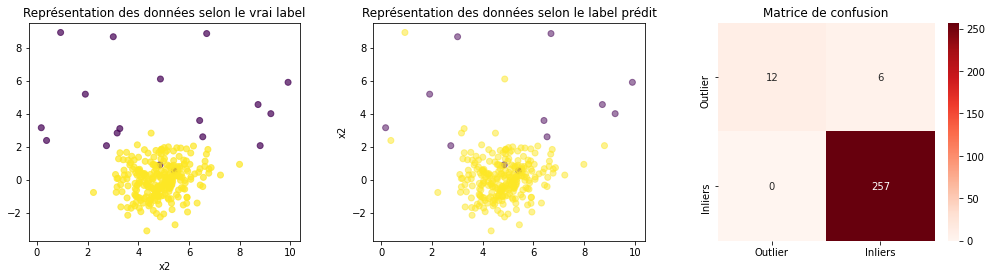

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.949091  0.611111                 0.0              0.051661


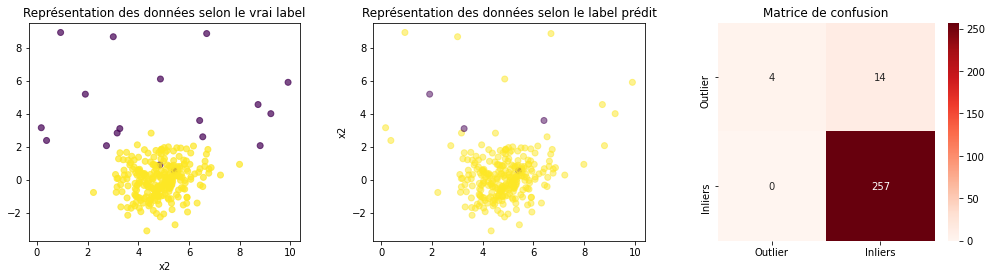

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.992727  0.996109            0.007782                   0.0


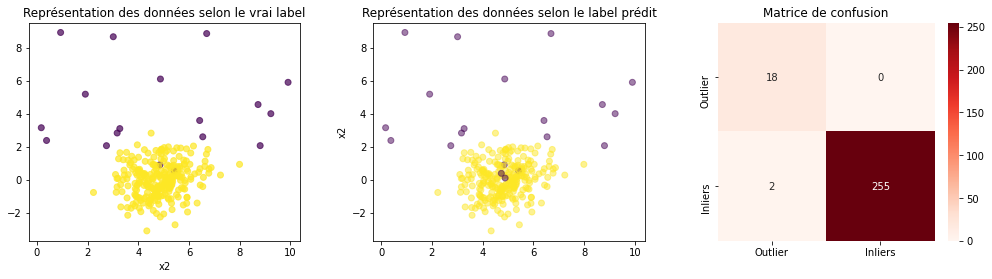

---------Local Outlier Factor-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.967273    0.75                 0.0              0.033835


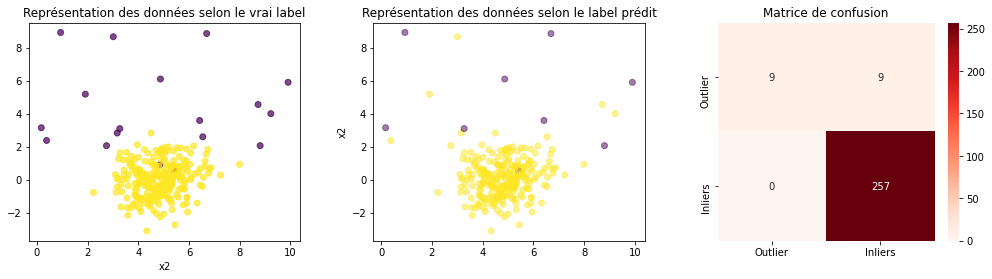

In [108]:
X = np.concatenate([normal_data,uniform_anomaly2])
y = np.concatenate([np.ones(1000),-np.ones(100)])

plot_var_in_out(X,y,1,0,2,3)

#outlier_prop = len(y[y==-1])/len(y) #0.012
outlier_prop = 0.03

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

for name, algorithm in anomaly_algorithms:
  if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    y_pred[y_pred == 1] = -1
    y_pred[y_pred == 0] = 1
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Local Outlier Factor":
    algorithm.fit(X_train)
    y_pred = algorithm.fit_predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Deep MLP":
    algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
    y_pred = deep_predict(algorithm,X_test_scaled)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  
  if name == "Robust covariance" :
    algorithm.fit(X_train)
    y_pred = -algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)

  if name not in algo_particuliers:
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)

# Deuxième représentation

## Gaussiennes

In [0]:
def evaluation_detection(ytrue,ypred):

  var1 = 0
  var2 = 1

  ind_col = np.zeros(len(ytrue))
  ytrue = np.squeeze(np.asarray(ytrue))
  ind_col[(ytrue == -1)&(ypred == -1)] = 1
  ind_col[(ytrue == 1)&(ypred == -1)] = 2
  ind_col[(ytrue == -1)&(ypred == 1)] = 3

  classes = ['Inlier en test et en prediction','Outlier en test et en prediction','Inlier manqué par le modèle','Outlier manqué par le modèle']
  col = ['yellow','green','blue','red']

  fig = plt.figure(figsize=(14,18))

  ax0 = fig.add_subplot(5,2,1)
  data = confusion_matrix(ytrue, ypred)
  labels = ['Outlier', 'Inliers']
  sns.heatmap(data, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Reds", ax=ax0) 
  ax0.set_title('Matrice de confusion')

  ax1 = fig.add_subplot(5,2,2)
  base = X_test[np.where(ind_col == 0)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[0], label = classes[0])
  base = X_test[np.where(ind_col == 1)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[1], label = classes[1])
  base = X_test[np.where(ind_col == 2)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[2], label = classes[2])
  base = X_test[np.where(ind_col == 3)]
  x1 = base[:,var1]
  x2 = base[:,var2]
  ax1.scatter(x1, x2, alpha = 0.7,c=col[3], label = classes[3])
  ax1.set_title('Représentation des données selon la différence entre le vrai label et la prévision')
  ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Catégorie")
  ax1.set_xlabel('x1') 
  ax1.set_ylabel('x2') 

  plt.tight_layout()
  plt.show()

%%%%%%%%%%%%%%%%%% index =  0


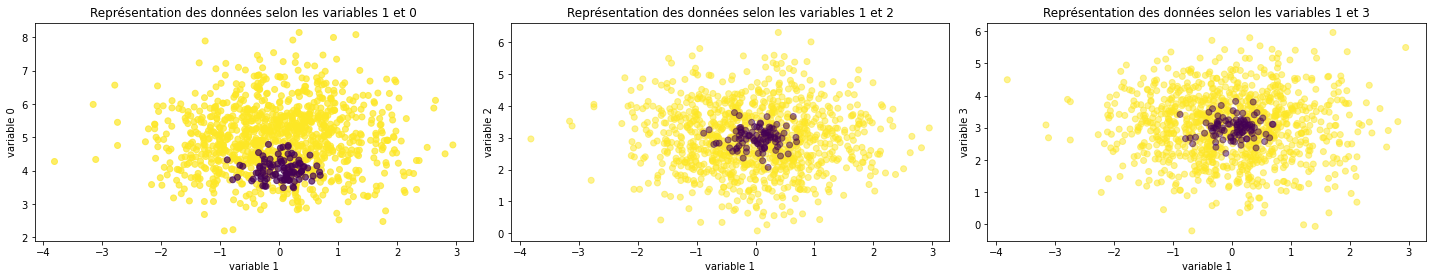

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.981818  0.861111                 0.0              0.019084


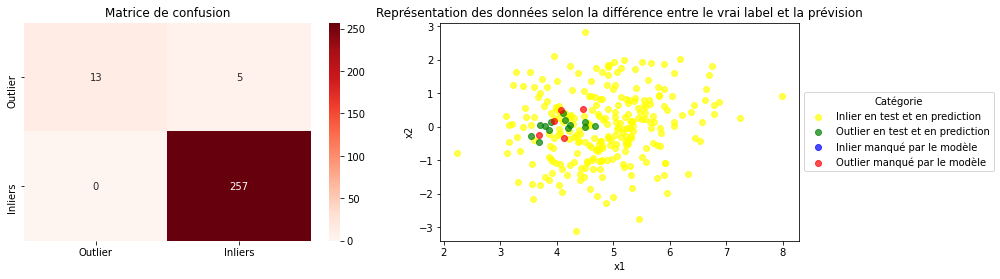

---------One-Class SVM-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.796364  0.42607             0.14786              0.075949


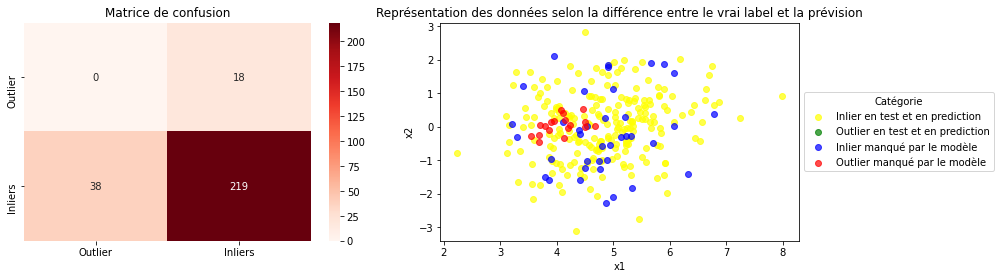

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.894545  0.478599            0.042802              0.068182


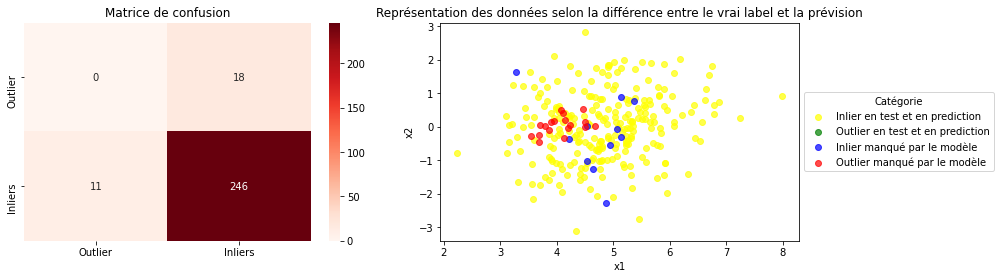

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.898182  0.480545            0.038911              0.067925


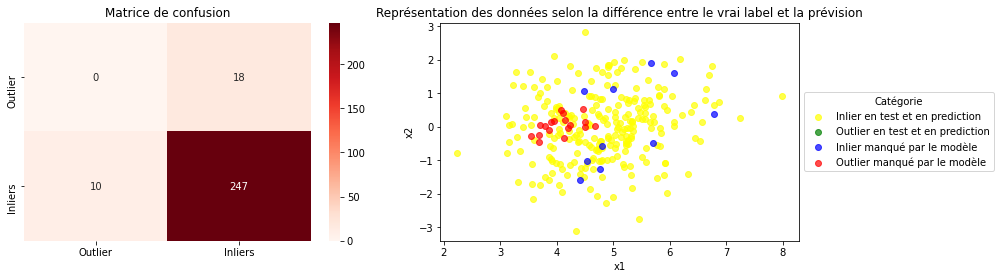

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


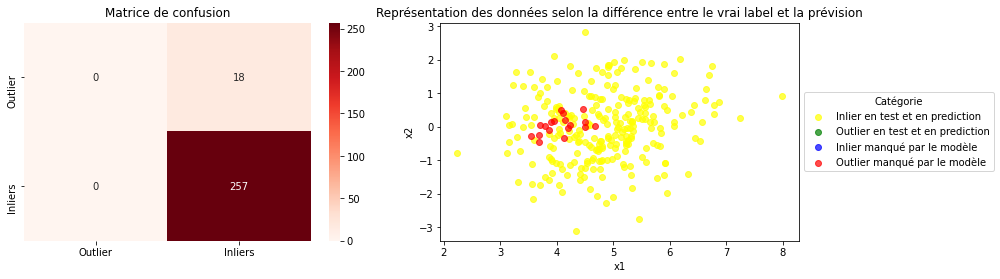

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


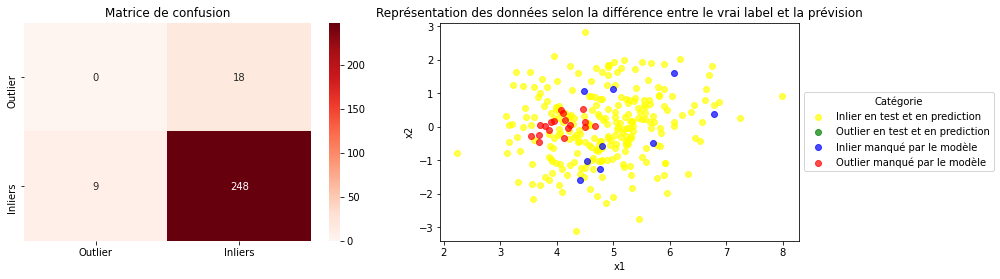

%%%%%%%%%%%%%%%%%% index =  1


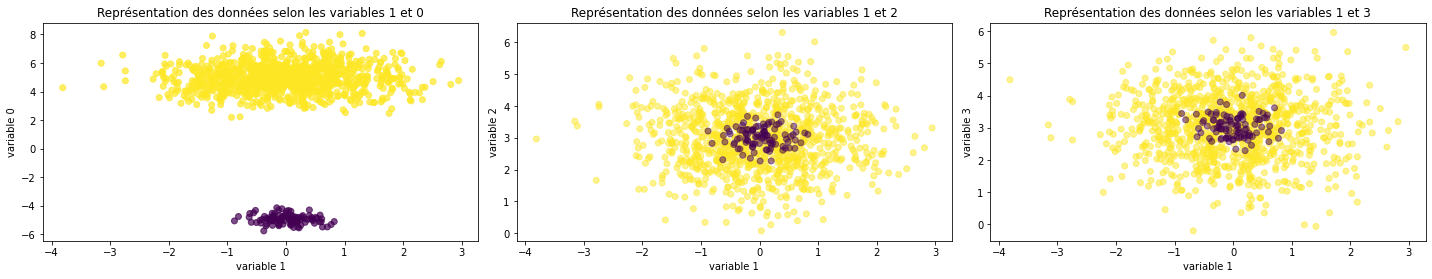

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.996364  0.972222                 0.0              0.003876


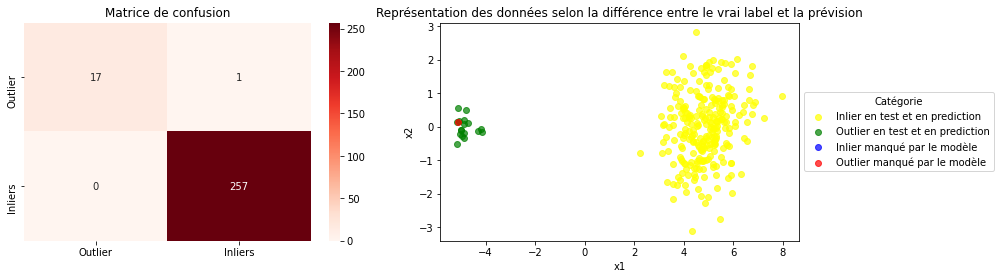

---------One-Class SVM-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.796364  0.42607             0.14786              0.075949


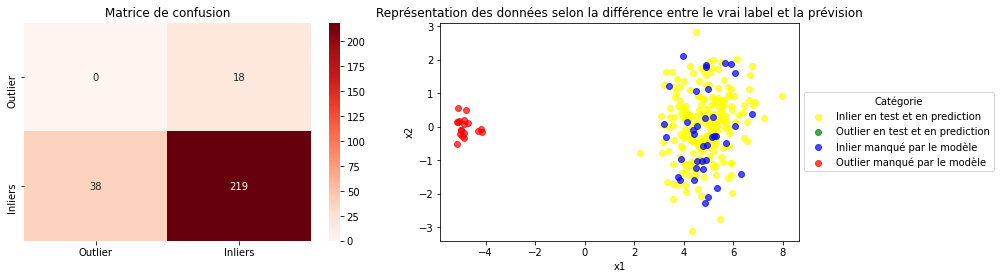

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.876364  0.468872            0.062257              0.069498


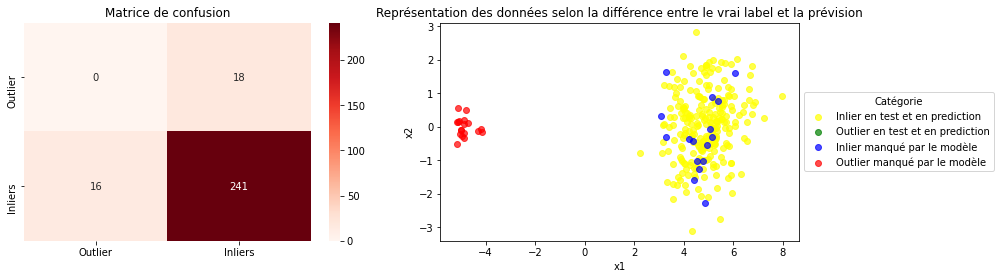

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.916364  0.490272            0.019455              0.066667


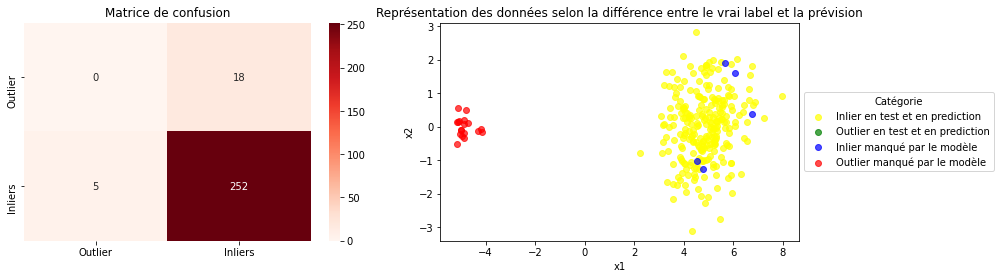

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


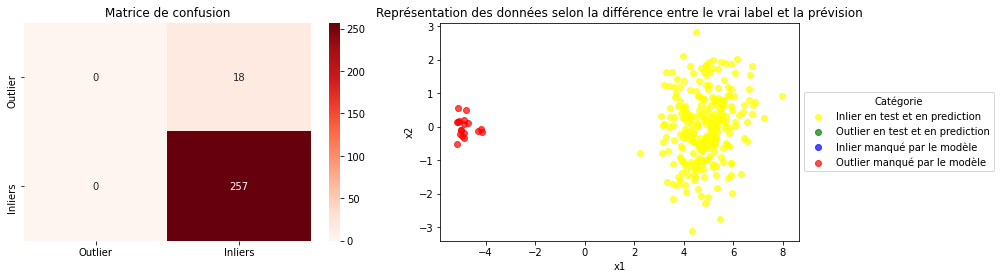

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


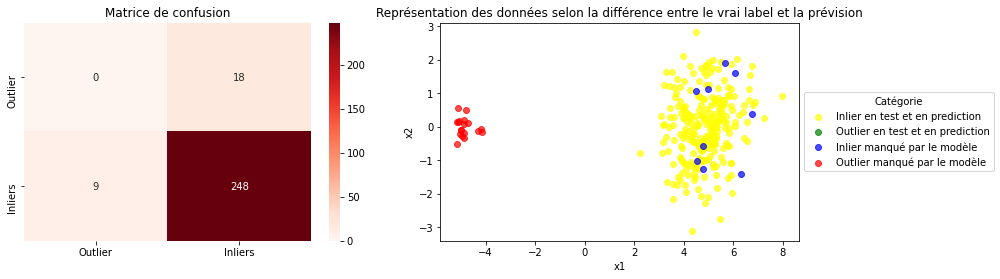

%%%%%%%%%%%%%%%%%% index =  2


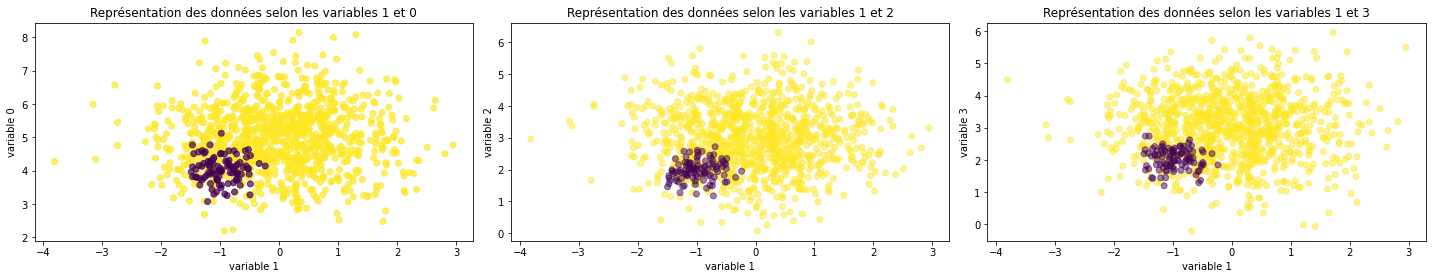

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.981818  0.861111                 0.0              0.019084


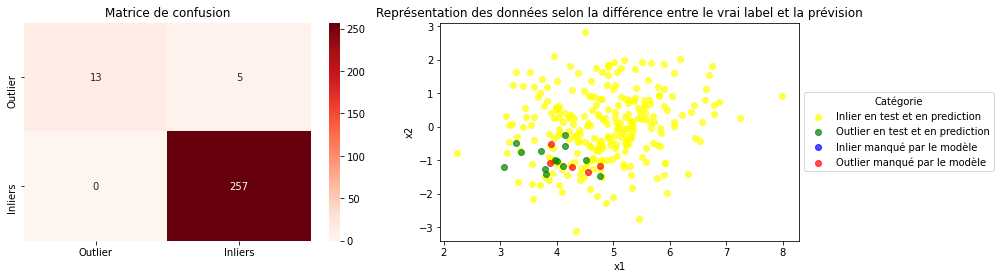

---------One-Class SVM-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.796364  0.42607             0.14786              0.075949


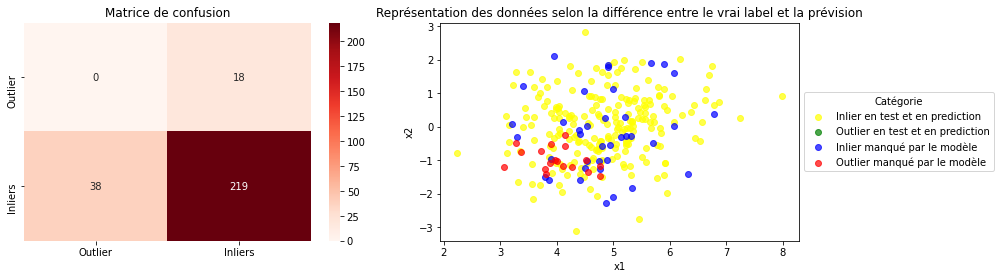

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.890909  0.476654            0.046693              0.068441


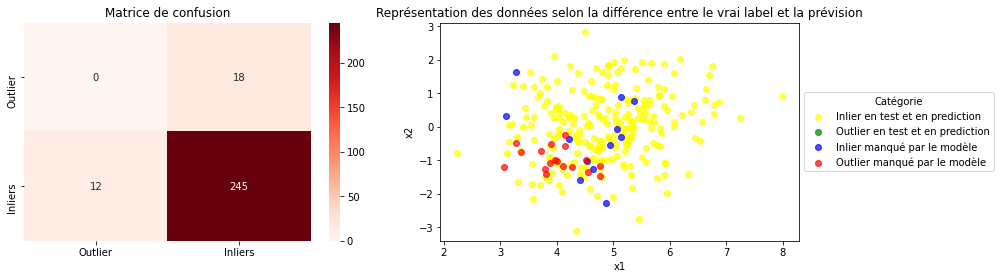

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.905455  0.484436            0.031128              0.067416


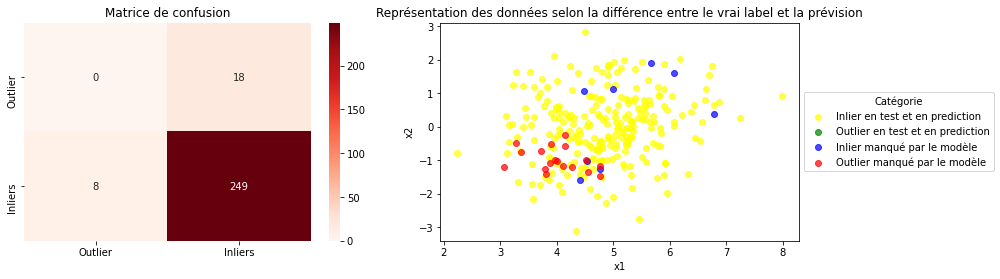

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


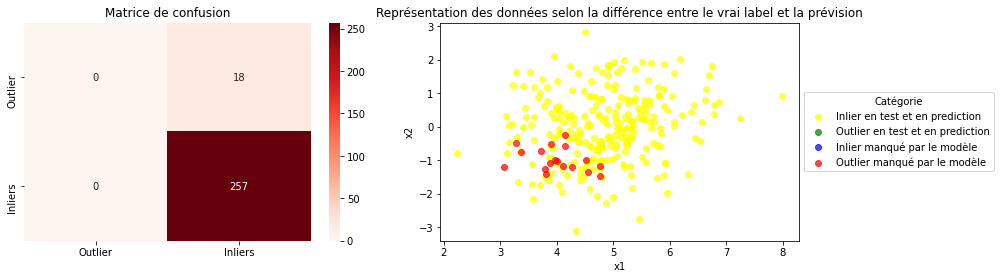

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


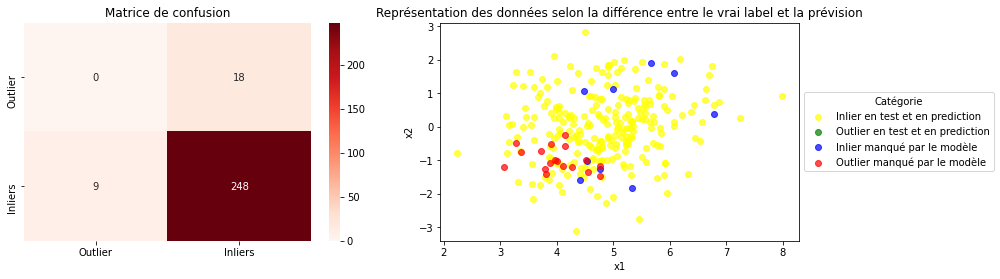

In [111]:
for index in range(len(anomaly_list_01)):
  print("%%%%%%%%%%%%%%%%%% index = ",index)
  X = np.concatenate([normal_data,anomaly_list_01[index]])
  y = np.concatenate([np.ones(1000),-np.ones(100)])

  plot_var_in_out(X,y,1,0,2,3)

  #outlier_prop = len(y[y==-1])/len(y) #0.012
  outlier_prop = 0.03

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled  = scaler.transform(X_test)

  for name, algorithm in anomaly_algorithms:
    if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      y_pred[y_pred == 1] = -1
      y_pred[y_pred == 0] = 1
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Local Outlier Factor":
      algorithm.fit(X_train)
      y_pred = algorithm.fit_predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Deep MLP":
      algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
      y_pred = deep_predict(algorithm,X_test_scaled)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    
    if name == "Robust covariance" :
      algorithm.fit(X_train)
      y_pred = -algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

    if name not in algo_particuliers:
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

%%%%%%%%%%%%%%%%%% index =  0


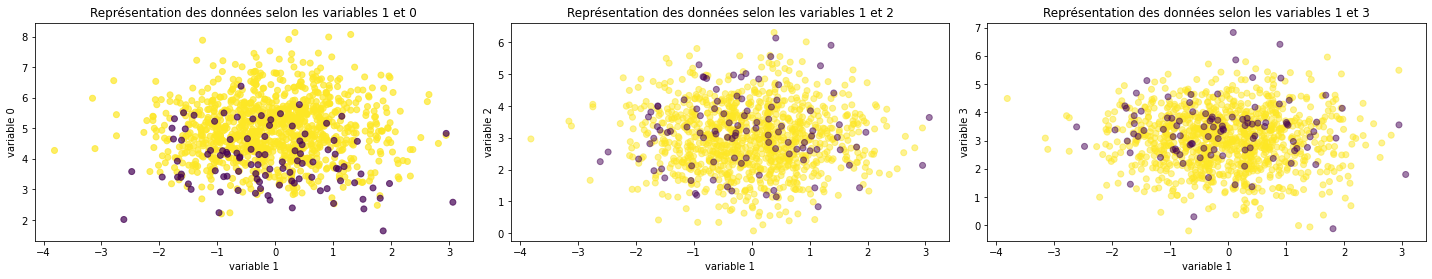

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


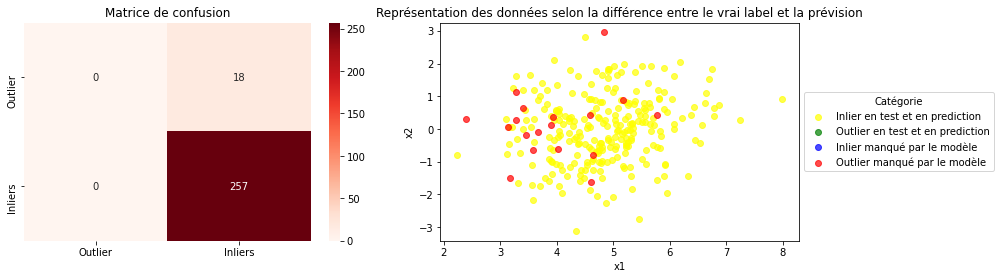

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.810909  0.537181             0.14786              0.060086


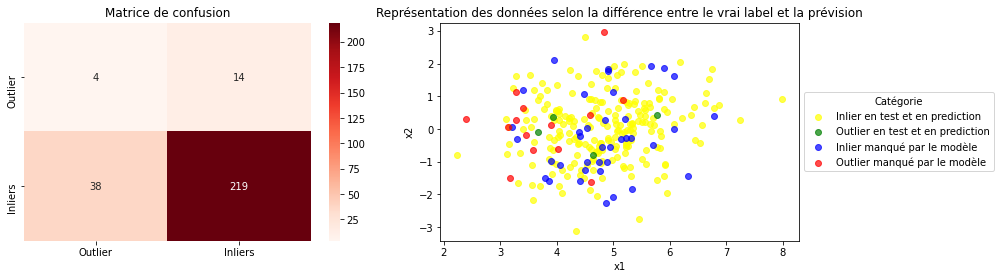

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.909091  0.538046            0.035019              0.060606


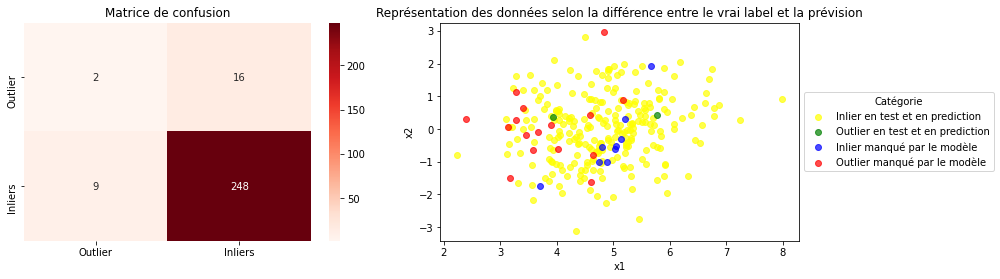

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.901818  0.508323            0.038911              0.064394


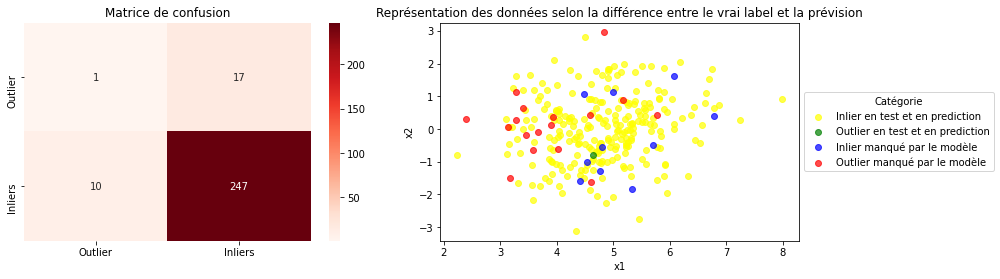

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


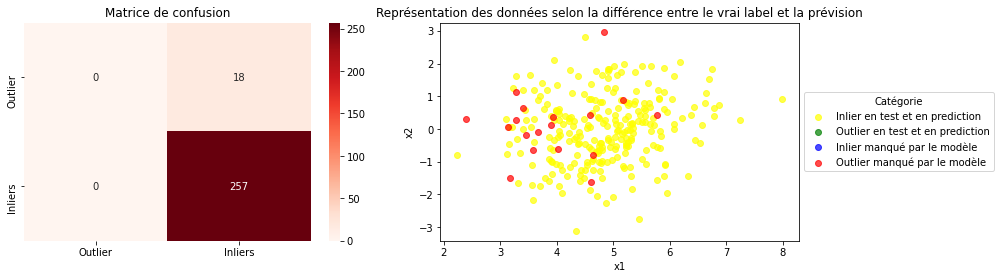

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.909091  0.512214            0.031128               0.06391


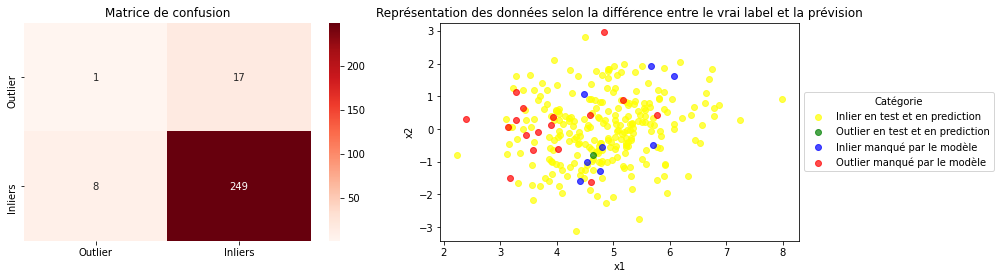

%%%%%%%%%%%%%%%%%% index =  1


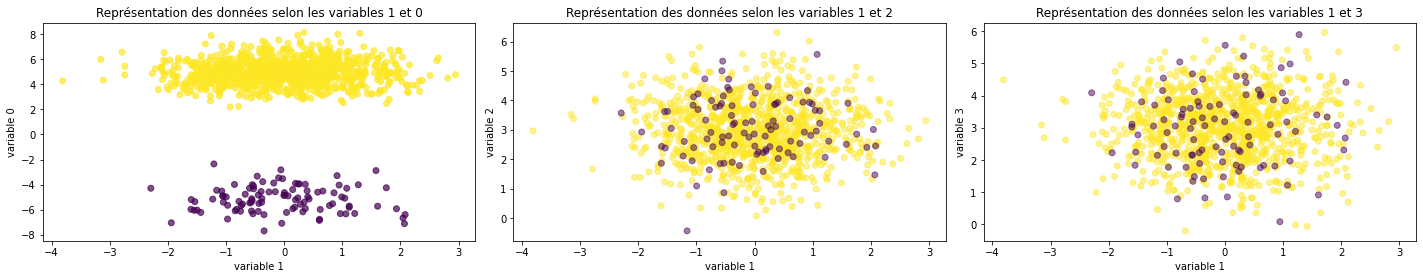

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


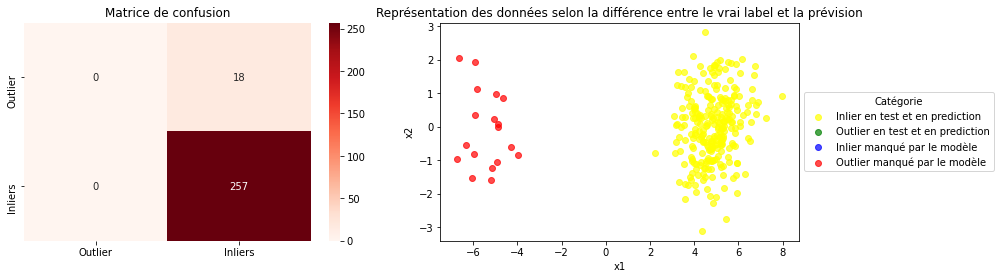

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.872727  0.647752            0.093385              0.045082


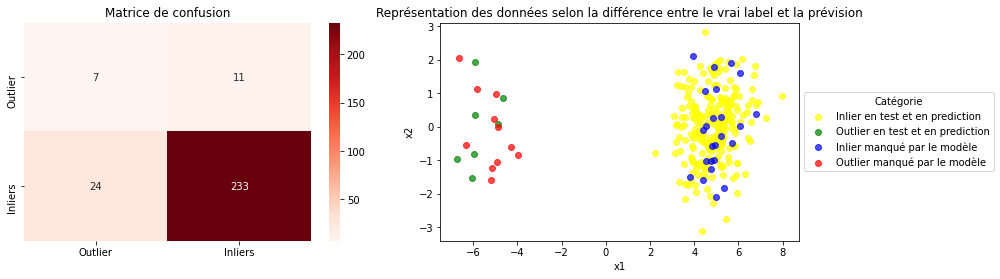

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.869091  0.516645            0.077821              0.063241


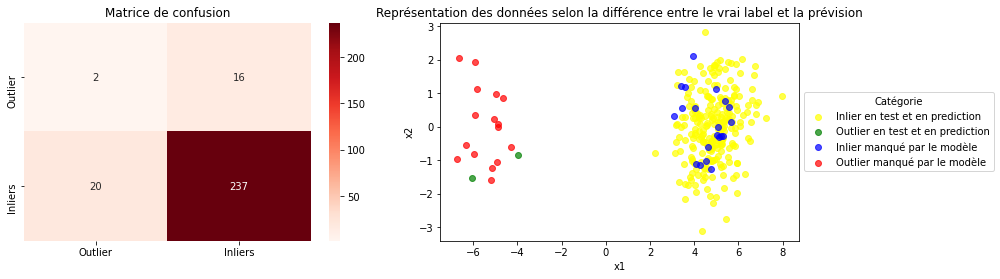

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.934545  0.577497            0.011673              0.055762


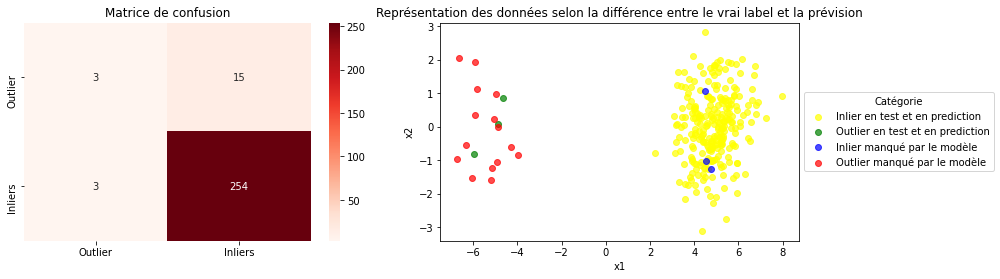

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


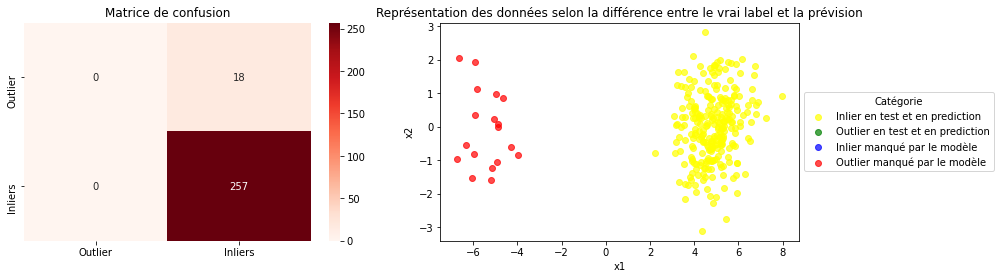

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.930909  0.601383            0.019455              0.052632


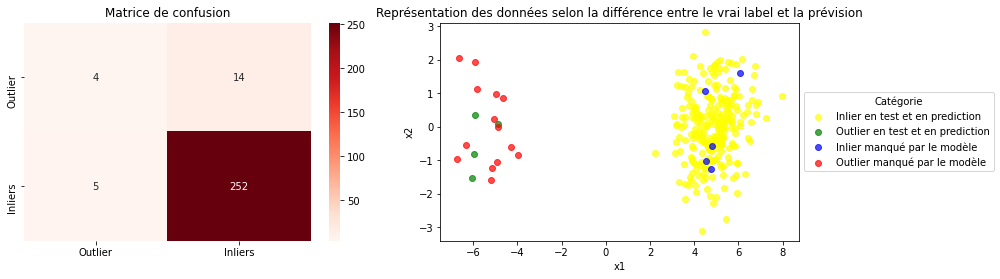

%%%%%%%%%%%%%%%%%% index =  2


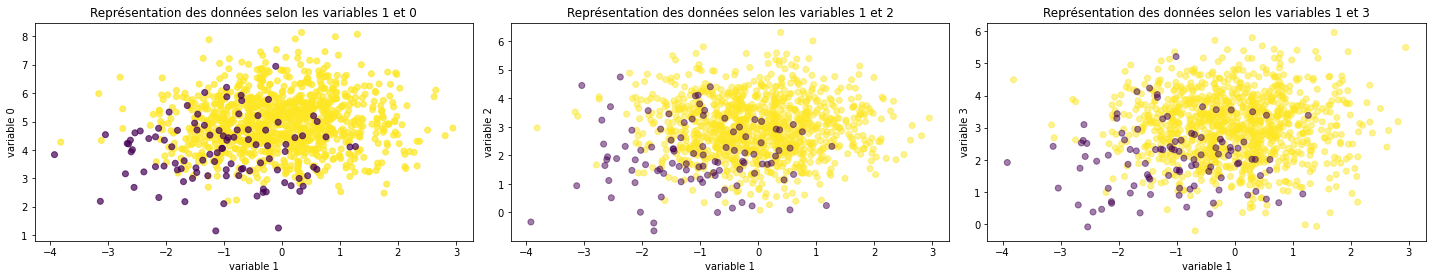

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


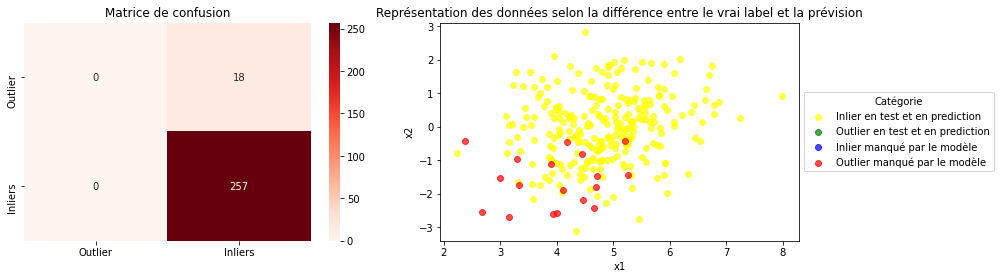

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.836364  0.524968            0.116732              0.061983


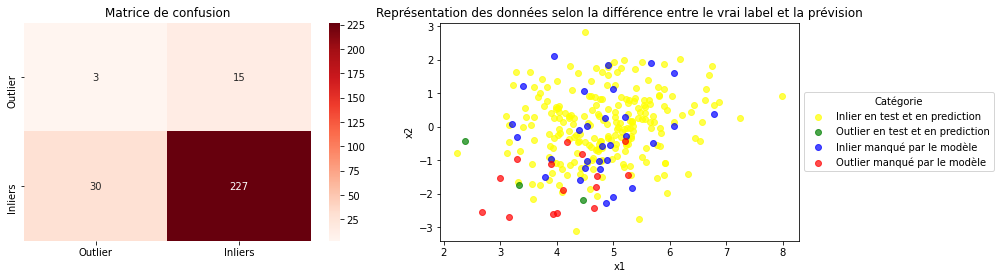

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.909091  0.512214            0.031128               0.06391


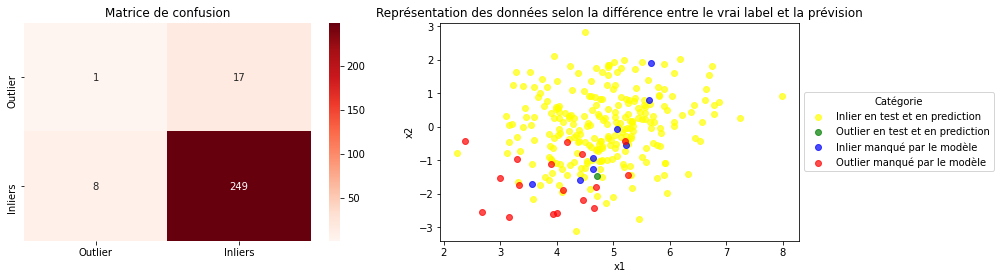

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.905455  0.484436            0.031128              0.067416


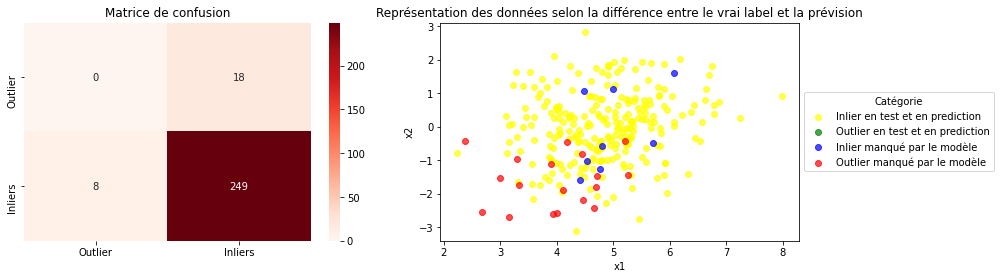

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.934545     0.5                 0.0              0.065455


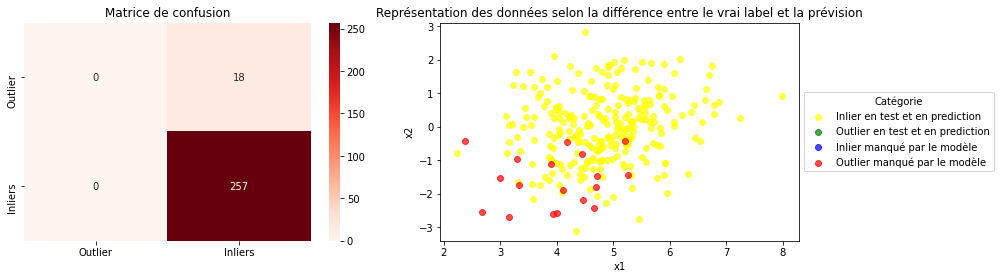

---------Local Outlier Factor-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.901818  0.48249            0.035019              0.067669


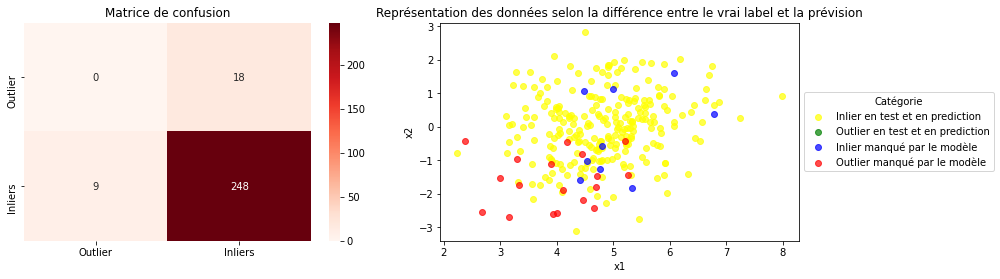

In [112]:
## std of 1

for index in range(len(anomaly_list_1)):
  print("%%%%%%%%%%%%%%%%%% index = ",index)
  X = np.concatenate([normal_data,anomaly_list_1[index]])
  y = np.concatenate([np.ones(1000),-np.ones(100)])

  plot_var_in_out(X,y,1,0,2,3)

  #outlier_prop = len(y[y==-1])/len(y) #0.012
  outlier_prop = 0.03

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled  = scaler.transform(X_test)

  for name, algorithm in anomaly_algorithms:
    if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      y_pred[y_pred == 1] = -1
      y_pred[y_pred == 0] = 1
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Local Outlier Factor":
      algorithm.fit(X_train)
      y_pred = algorithm.fit_predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    if name == "Deep MLP":
      algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
      y_pred = deep_predict(algorithm,X_test_scaled)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)
    
    if name == "Robust covariance" :
      algorithm.fit(X_train)
      y_pred = -algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

    if name not in algo_particuliers:
      algorithm.fit(X_train)
      y_pred = algorithm.predict(X_test)
      print('---------'+name+'-----------')
      print(evaluate(y_test,y_pred))
      evaluation_detection(y_test,y_pred)

## Uniforme

In [0]:
X = np.concatenate([normal_data,uniform_anomaly])
y = np.concatenate([np.ones(1000),-np.ones(100)])

plot_var_in_out(X,y,1,0,2,3)

#outlier_prop = len(y[y==-1])/len(y) #0.012
outlier_prop = 0.03

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

for name, algorithm in anomaly_algorithms:
  if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    y_pred[y_pred == 1] = -1
    y_pred[y_pred == 0] = 1
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Local Outlier Factor":
    algorithm.fit(X_train)
    y_pred = algorithm.fit_predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Deep MLP":
    algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
    y_pred = deep_predict(algorithm,X_test_scaled)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  
  if name == "Robust covariance" :
    algorithm.fit(X_train)
    y_pred = -algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)

  if name not in algo_particuliers:
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)

In [0]:
X = np.concatenate([normal_data,uniform_anomaly2])
y = np.concatenate([np.ones(1000),-np.ones(100)])

plot_var_in_out(X,y,1,0,2,3)

#outlier_prop = len(y[y==-1])/len(y) #0.012
outlier_prop = 0.03

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

for name, algorithm in anomaly_algorithms:
  if (name == "KNN") | (name == "ABOD") | (name == "HBOS"):
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    y_pred[y_pred == 1] = -1
    y_pred[y_pred == 0] = 1
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Local Outlier Factor":
    algorithm.fit(X_train)
    y_pred = algorithm.fit_predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  if name == "Deep MLP":
    algorithm.fit(X_train_scaled, X_train_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_split=0.33, verbose=0)
    y_pred = deep_predict(algorithm,X_test_scaled)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)
  
  if name == "Robust covariance" :
    algorithm.fit(X_train)
    y_pred = -algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)

  if name not in algo_particuliers:
    algorithm.fit(X_train)
    y_pred = algorithm.predict(X_test)
    print('---------'+name+'-----------')
    print(evaluate(y_test,y_pred))
    evaluation_detection(y_test,y_pred)